In [1]:
import cv2
import numpy as np
import imutils
from utils.cttutils import displayImage
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
from utils.imageutils import crop
from utils.cttutils import midpoint
from utils.imageutils import DoGrayscaleAndBlur
from utils.calibrateutils import calculateMetric


## Side Processing

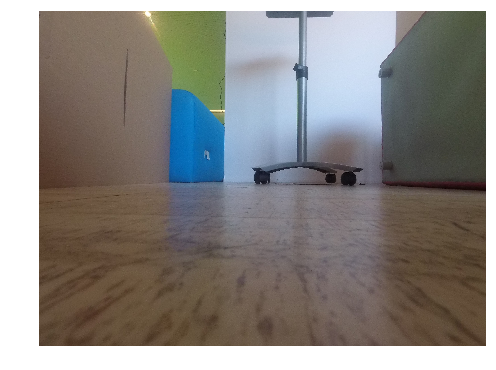

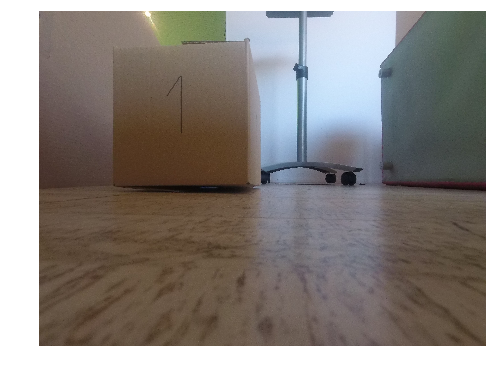

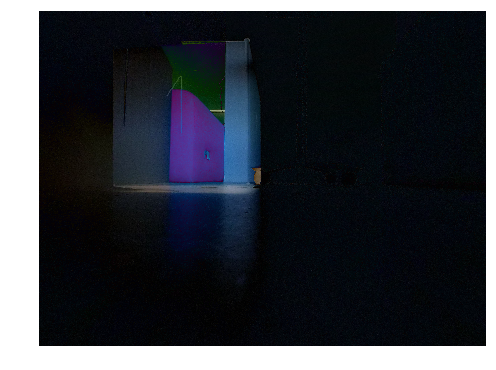

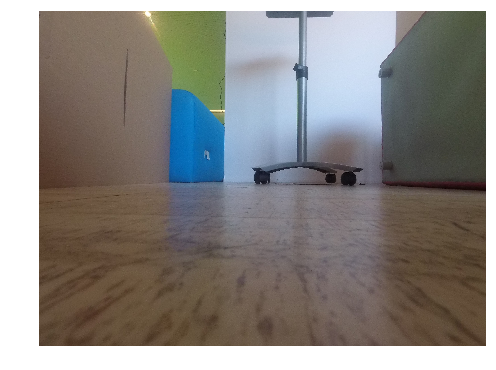

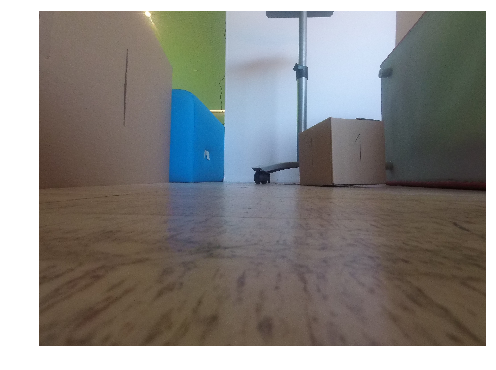

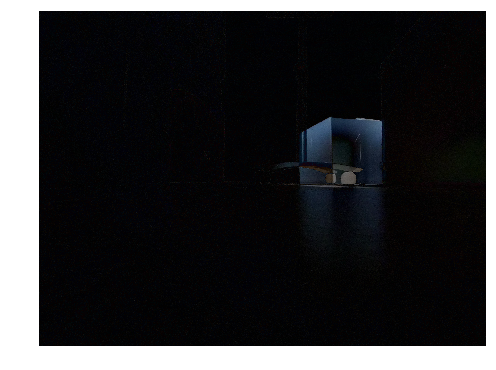

In [15]:
side1 = cv2.imread("resources/calibrationimages/side_calibration_1.JPG")
side2 = cv2.imread("resources/calibrationimages/side_calibration_1a.JPG")
bgside = cv2.imread("resources/calibrationimages/bg_calibration_side.JPG")

width = 1000
height = 1000
startX = 1200
startY = 1000
    
#side1 = crop(side1, width, height, startX, startY)
#side2 = crop(side2, width, height, startX, startY)
#bgside = crop(bgside, width, height, startX, startY)

hppm1, boxes_s1 = calculateMetric(19.5, side1, bgside, 'height', 70)
hppm2, boxes_s2 = calculateMetric(19.5, side2, bgside, 'height', 70)


In [17]:
print(hppm1)
print(hppm2)
#print(boxes_s1)
#print(boxes_s2)

40.74575198793684
0.8988999047670823


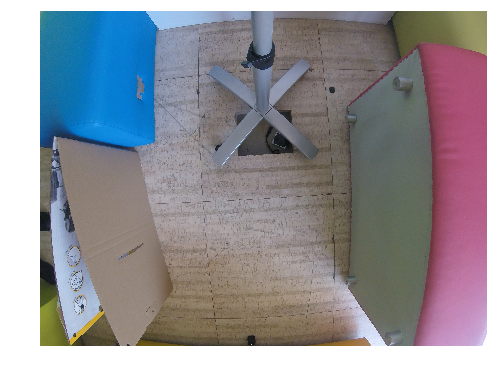

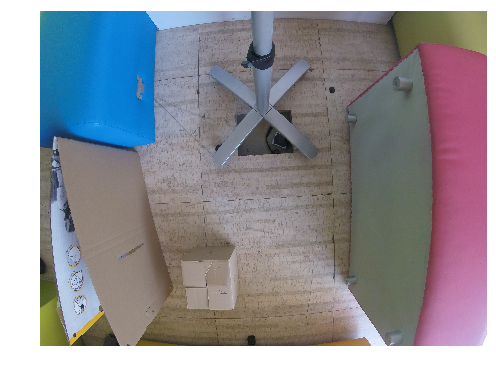

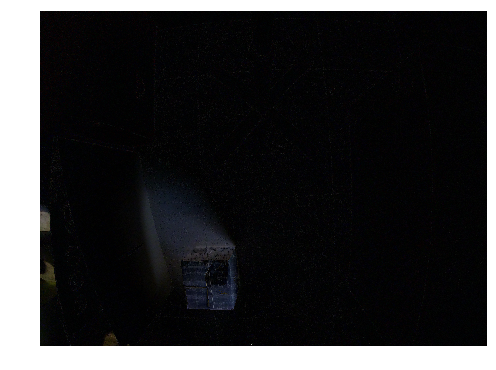

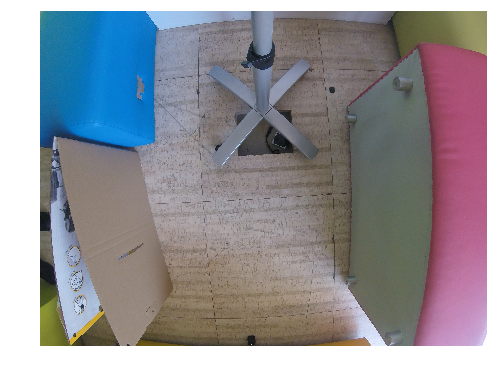

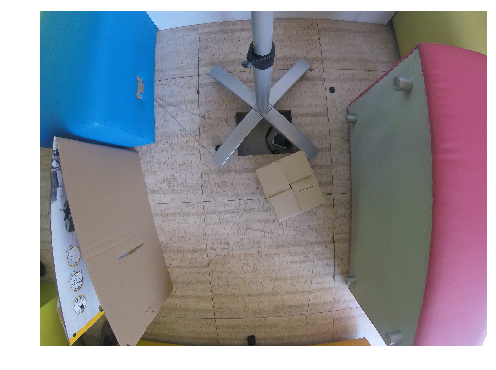

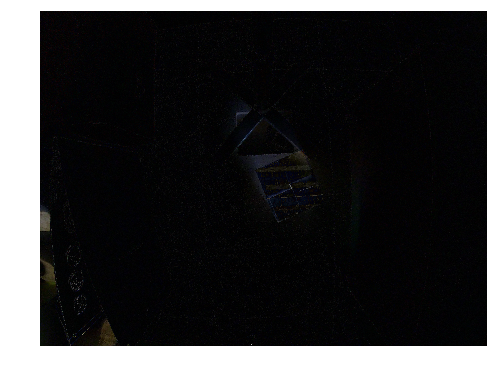

In [5]:
top1 = cv2.imread("resources/calibrationimages/top_calibration_1.JPG")
top2 = cv2.imread("resources/calibrationimages/top_calibration_1a.JPG")
bgtop = cv2.imread("resources/calibrationimages/bg_calibration_top.JPG")

top1 = imutils.rotate(top1,180)
top2 = imutils.rotate(top2, 180)
bgtop = imutils.rotate(bgtop, 180)

width = 1050
height = 1080
startX = 550
startY = 450

#top1 = crop(top1, width, height, startX, startY)
#top2 = crop(top2, width, height, startX, startY)
#bgtop = crop(bgtop, width, height, startX, startY)

wppm1, boxes_t1 = calculateMetric(21.5, top1, bgtop, 'width', 70)
wppm2, boxes_t2 = calculateMetric(21.5, top2, bgtop, 'width', 70)

b = boxes_t1[0]
x1 = top1.shape[0]- np.max(b[:,1])
b = boxes_t2[0]
x2 = top2.shape[0]- np.max(b[:,1])

In [6]:
side_b = (hppm2*x1 - hppm1*x2) / (-x2 + x1)
side_m = (hppm1 - side_b) / x1

In [7]:
print(side_b,side_m)

27814.00165395726 -39.846852083169765


## END OF CALIBRATION OF SIDE CAMERA

## Top Processing

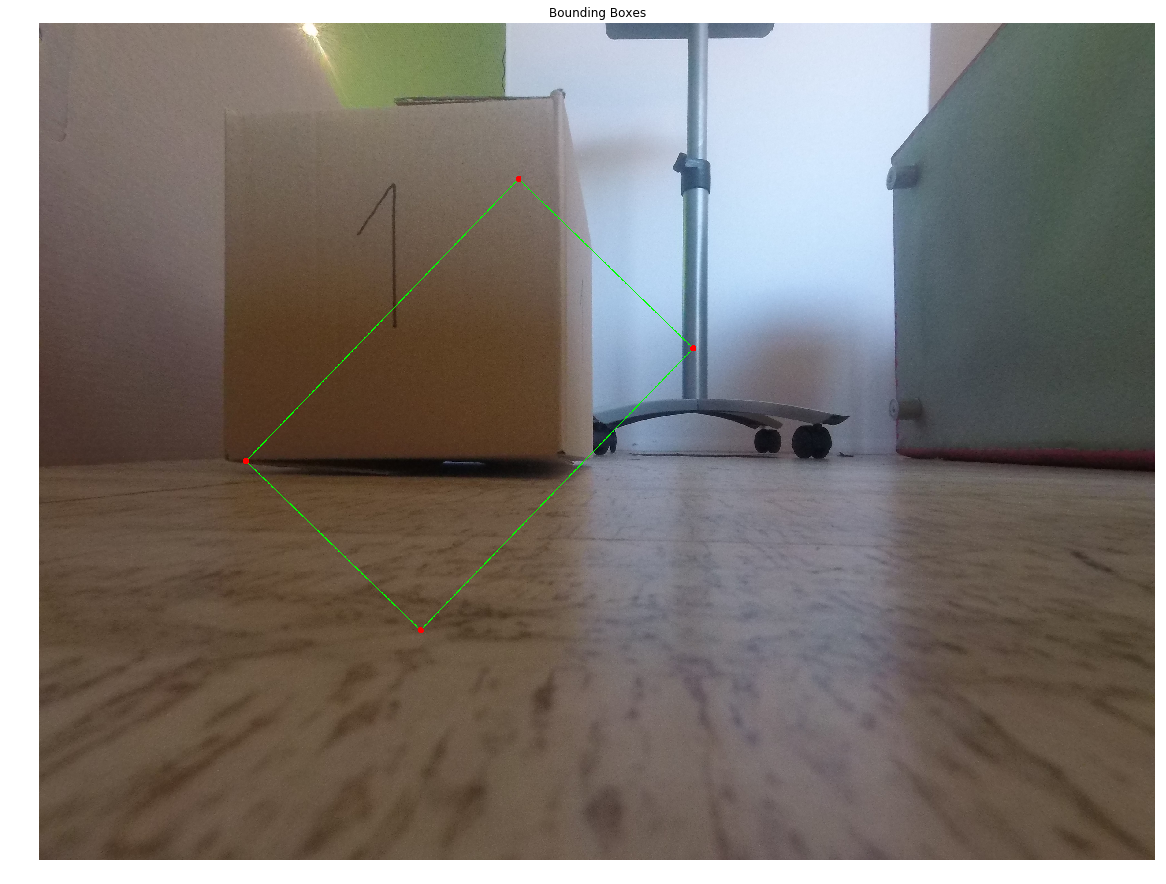

In [8]:
b = boxes_s1[0]
orig = side1.copy()

cv2.drawContours(orig, [b.astype("int")], -1, (0, 255, 0), 2)
for (x, y) in b:
    cv2.circle(orig, (int(x), int(y)), 10, (0, 0, 255), -1)

displayImage(orig, title="Bounding Boxes", figSize=(20,20))

In [9]:
b = boxes_s1[0]
x1 = np.min(b[:,1])
b = boxes_s2[0]
x2 = np.min(b[:,1])

In [10]:
top_b = (wppm2*x1 - wppm1*x2) / (-x2 + x1)
top_m = (wppm1 - top_b) / x1

print(top_b,top_m)


2.9568106312292355 -5.191029900332173e-05


## END OF CALIBRATION OF TOP CAMERA

In [11]:
print(side_b, side_m, top_b, top_m)

27814.00165395726 -39.846852083169765 2.9568106312292355 -5.191029900332173e-05


## START OF MEASURING PROCESS

In [12]:
side_b, side_m, top_b, top_m = 20.3059886137, -0.0179589246428, 11.9336384688, 0.0041337541737
def calculatePpm(x, m, b):
    ppm = x*m + b
    return ppm

In [13]:
def calculateSize(img, bg_img, ppm, th):
    diff = cv2.absdiff(bg_img, img)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    imask =  mask>th
    canvas = np.zeros_like(img, np.uint8)
    canvas[:] = 255
    canvas[imask] = img[imask]
    # perform edge detection, then perform a dilation + erosion to
    # close gaps in between object edges
    result = DoGrayscaleAndBlur(canvas)
    edged = cv2.Canny(result, 180, 200)
    edged = cv2.dilate(edged, None, iterations=2)
    edged = cv2.erode(edged, None, iterations=1)
     # find contours in the edge map
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]

    # sort the contours from left-to-right and initialize the
    # 'pixels per metric' calibration variable
    (cnts, _) = contours.sort_contours(cnts, method='left-to-right')
    
    # get areas for all contours
    areas = []
    for c in cnts:
        a = cv2.contourArea(c)
        areas.append(a)
    
    areas = np.array(areas)
    cnts = np.array(cnts)

    # remove small contours
    cnts = cnts[np.where(areas >= 600)[0]]
    
    # remove areas of removed contours
    areas = areas[np.where(areas >= 600)[0]]
    
    # loop over the contours individually and get bounding boxes
    boxes = []
    for c in cnts:
    
        # compute the rotated bounding box of the contour
        box = cv2.minAreaRect(c)
        box = cv2.boxPoints(box) 
        box = np.array(box, dtype="int")
 
        # order the points in the contour such that they appear
        # in top-left, top-right, bottom-right, and bottom-left
        # order, then draw the outline of the rotated bounding
        # box
        box = perspective.order_points(box)
        boxes.append(box)

    boxes = np.array(boxes)
    object_sizes = []

    for box in boxes:
        # unpack the ordered bounding box, then compute the midpoint
        # between the top-left and top-right coordinates, followed by
        # the midpoint between bottom-left and bottom-right coordinates
        (tl, tr, br, bl) = box
        (tltrX, tltrY) = midpoint(tl, tr)
        (blbrX, blbrY) = midpoint(bl, br)
 
        # compute the midpoint between the top-left and top-right points,
        # followed by the midpoint between the top-righ and bottom-right
        (tlblX, tlblY) = midpoint(tl, bl)
        (trbrX, trbrY) = midpoint(tr, br)
 
        # compute the Euclidean distance between the midpoints
        dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
        dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
 
        # compute the size of the object
        dimA = dA / ppm
        dimB = dB / ppm

    return dimA, dimB